In [1]:
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from tokenizers import Tokenizer, models, trainers
from tokenizers.normalizers import NFKC
from tokenizers.pre_tokenizers import Whitespace
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

plt.style.use('ggplot')

> In this EDA you won't see useless or usual plots like wordcloud (weighted by token frequency) present in every NLP projects made by students, but you will discover an original way to explore a corpus/dataset and to find some insights. All plots will impact the training step & the error analysis.  
>  
> 
> Enjoy :)

In [6]:
ds = load_dataset("WhereIsAI/github-issue-similarity", "default")

In [7]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 18565
    })
    valid: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1548
    })
})


In [8]:
ds["train"] = ds["train"].filter(lambda x: x["text1"] != "" and x["text2"] != "")
ds["valid"] = ds["valid"].filter(lambda x: x["text1"] != "" and x["text2"] != "")
ds["test"] = ds["test"].filter(lambda x: x["text1"] != "" and x["text2"] != "")

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 18426
    })
    valid: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1538
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 1539
    })
})

In [10]:
texts = []

for split in tqdm(["train", "valid", "test"]):
    texts.extend(ds[split]["text1"])
    texts.extend(ds[split]["text2"])

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
print(len(texts))

43006


> Let's build a BPE tokenizer trained on our campus. We will normalize the characters, pre-tokenize by splitting by white space and finally train with a vocab_size largely used in the litterature.  

> This one willbe usefful to estimate the minimum max input tokens. How and Why ? You won't be able to find a better tokenizer, so if the mean number of tokens of our dataset tokenized with the perfect tokenizer is 7000, using BERT (512) might be problematic.

In [9]:
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
trainer = trainers.BpeTrainer(vocab_size=30522)
tokenizer.train_from_iterator(texts, trainer=trainer)

In [11]:
tokenizer.save("perfect_tokenizer.json")

In [48]:
tokenizer = Tokenizer.from_file("perfect_tokenizer.json")

In [49]:
vocab = tokenizer.get_vocab()
print(len(vocab))

30522


In [16]:
sample = ds["train"]["text1"][0]

print("Sample text:")
print("*"*80)
print(sample)
print("\n\n")
print("Encoded text:")
print("*"*80)
print(tokenizer.encode(sample).tokens)

Sample text:
********************************************************************************
<h3 dir="auto">Feature request</h3>
<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>
As in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>
<h3 dir="auto">Motivation</h3>
<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>
<blockquote>
<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? 

In [17]:
def get_n_tokens(sample, tokenizer, key="token_length"):
    try:
        return {
            f"{key}_text1": len(tokenizer.encode(sample["text1"], add_special_tokens=False).tokens),
            f"{key}_text2": len(tokenizer.encode(sample["text2"], add_special_tokens=False).tokens)
        }
    except:
        return {
            f"{key}_text1": len(tokenizer(sample["text1"], add_special_tokens=False).input_ids),
            f"{key}_text2": len(tokenizer(sample["text2"], add_special_tokens=False).input_ids)
        }


In [18]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizer), num_proc=48)

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

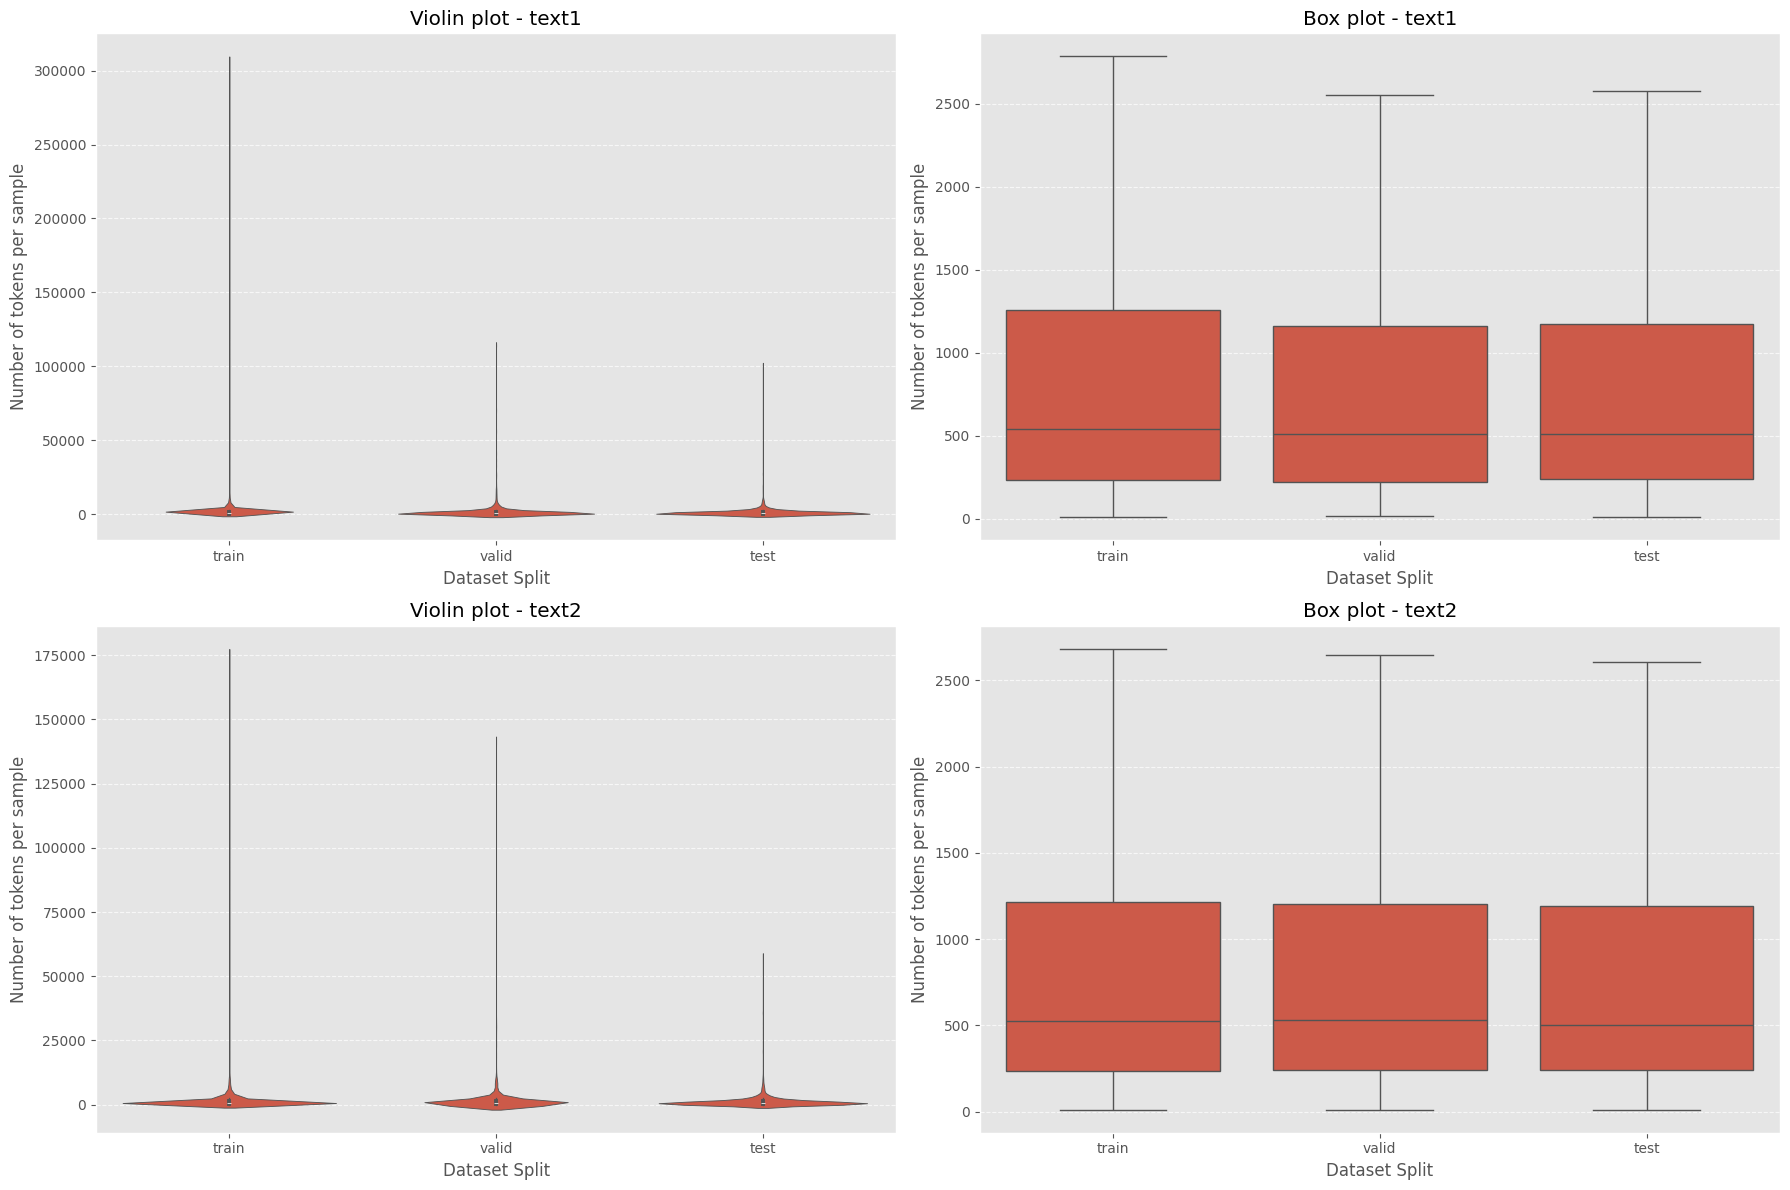

In [19]:
data_text1 = []
labels_text1 = []
data_text2 = []
labels_text2 = []

for split in ["train", "valid", "test"]:
    data_text1.extend(ds[split]["token_length_text1"])
    labels_text1.extend([split] * len(ds[split]["token_length_text1"]))

    data_text2.extend(ds[split]["token_length_text2"])
    labels_text2.extend([split] * len(ds[split]["token_length_text2"]))

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)

sns.violinplot(x=labels_text1, y=data_text1, inner="box", ax=axes[0, 0])
axes[0, 0].set_xlabel("Dataset Split")
axes[0, 0].set_ylabel("Number of tokens per sample")
axes[0, 0].set_title("Violin plot - text1")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=labels_text1, y=data_text1, ax=axes[0, 1], showfliers=False)
axes[0, 1].set_xlabel("Dataset Split")
axes[0, 1].set_ylabel("Number of tokens per sample")
axes[0, 1].set_title("Box plot - text1")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

sns.violinplot(x=labels_text2, y=data_text2, inner="box", ax=axes[1, 0])
axes[1, 0].set_xlabel("Dataset Split")
axes[1, 0].set_ylabel("Number of tokens per sample")
axes[1, 0].set_title("Violin plot - text2")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=labels_text2, y=data_text2, ax=axes[1, 1], showfliers=False)
axes[1, 1].set_xlabel("Dataset Split")
axes[1, 1].set_ylabel("Number of tokens per sample")
axes[1, 1].set_title("Box plot - text2")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

> SBERT based on the BERT architecture are not adapted here, because even with a perfect tokenizer, we will truncate the majority of the samples  

> Thus we select good candidates based on the size of our sampled and the performances in MTEB

In [20]:
models = {
    "Alibaba-NLP/gte-base-en-v1.5": 8192,
    # "jxm/cde-small-v2": 512,
    "bert-base-uncased": 512,  # The tokenizer used by cde-small-v2 is the same as bert-base-uncased (see hf repo)
    "NovaSearch/stella_en_400M_v5": 8192,
}

tokenizers = {model: AutoTokenizer.from_pretrained(model) for model in models}

In [21]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["Alibaba-NLP/gte-base-en-v1.5"], key="gte_token_length"), num_proc=48)
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["bert-base-uncased"], key="cde_token_length"), num_proc=48)
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["NovaSearch/stella_en_400M_v5"], key="stella_token_length"), num_proc=48)

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (33168 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (32917 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35455 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35487 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (80734 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (34943 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (50989 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (46430 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35264 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (81903 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (43344 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38117 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (90771 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (62184 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (36997 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1838 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (754 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1096 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (787 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (893 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3119 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1115 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1056 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (33168 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (32917 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35487 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35455 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (80734 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (34943 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (50989 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (46430 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (35264 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (81903 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (43344 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38117 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (90771 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (36997 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (62184 > 32768). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

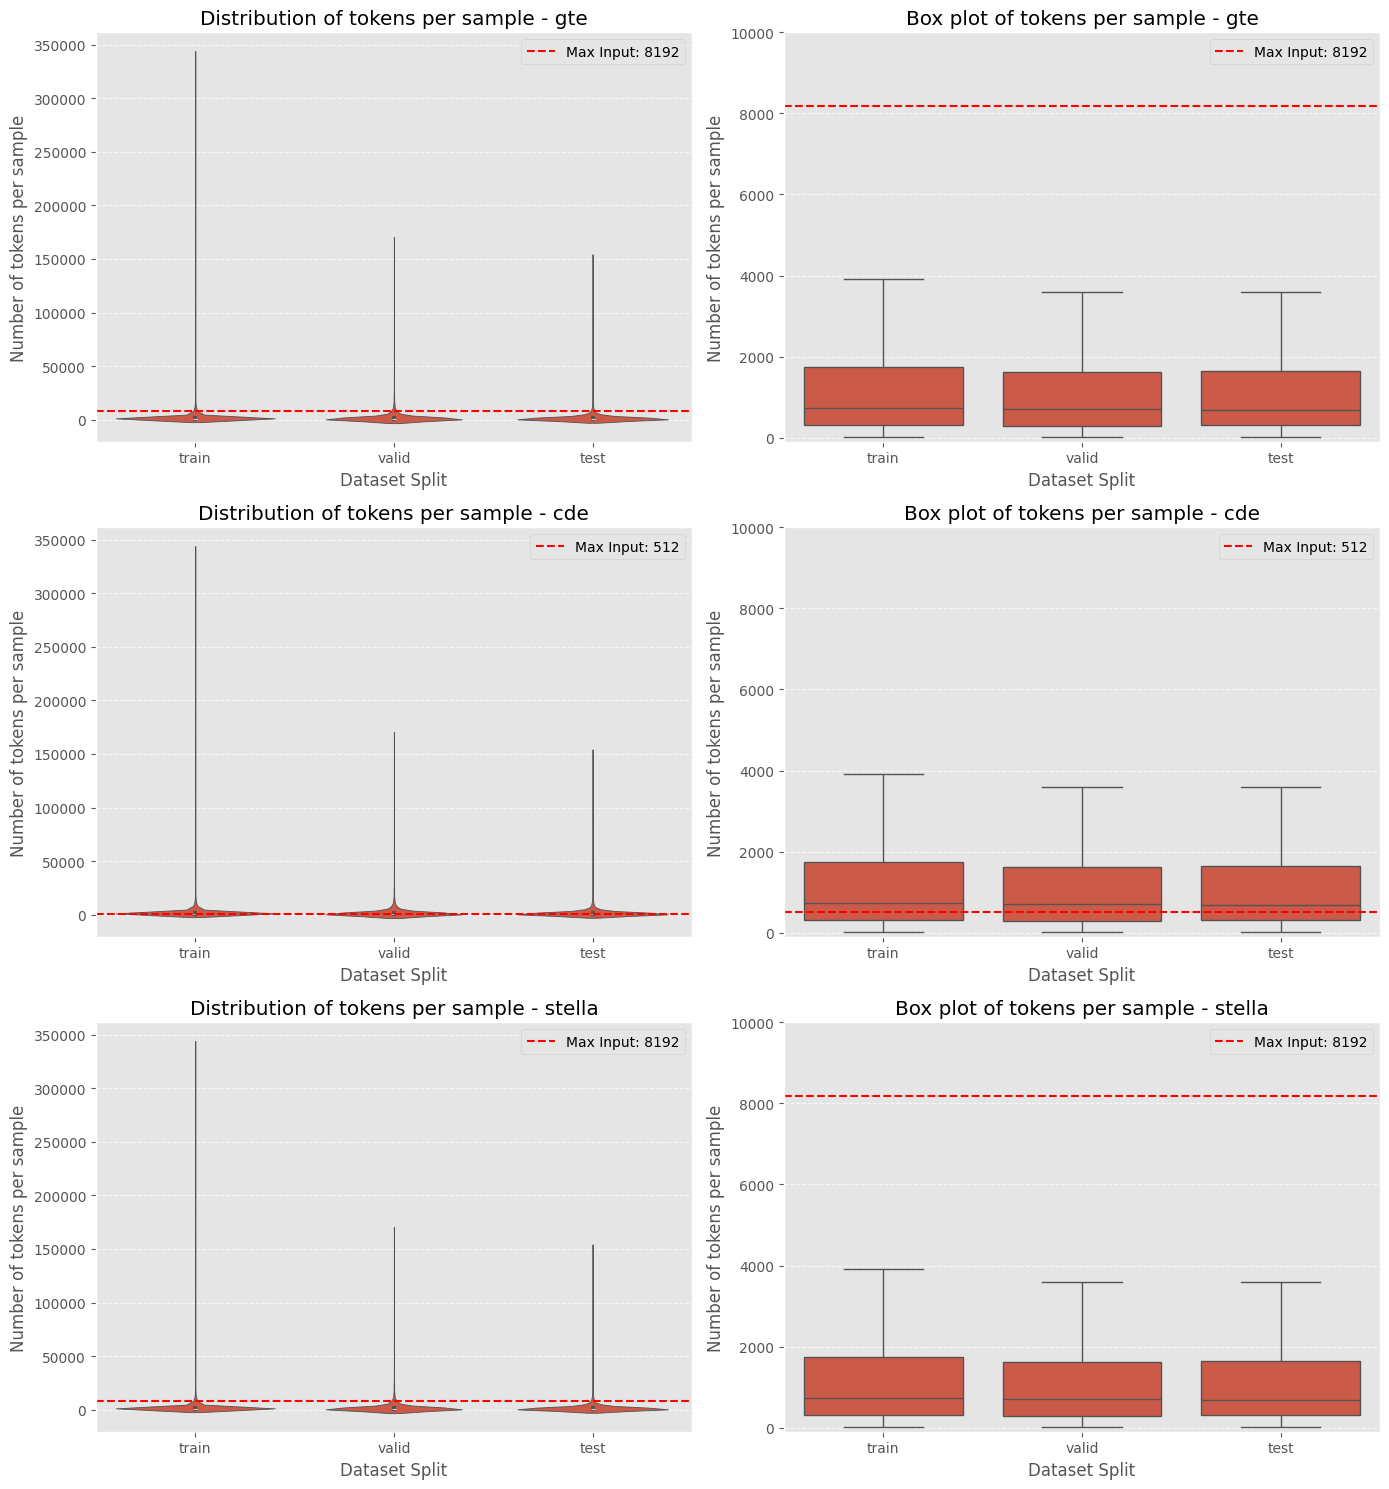

In [22]:
models = {
    "gte": 8192,
    "cde": 512,
    "stella": 8192,
}

fig, axes = plt.subplots(len(models), 2, figsize=(14, 15), sharey=False)

for (model_key, max_length), ax in zip(models.items(), axes):
    data = []
    labels = []

    for split in ["train", "valid", "test"]:
        token_length_column = f"{model_key}_token_length_text1"
        
        data.extend(ds[split][token_length_column])
        labels.extend([split] * len(ds[split][token_length_column]))

    sns.violinplot(x=labels, y=data, inner="box", ax=ax[0])
    ax[0].axhline(y=max_length, color='r', linestyle='--', label=f"Max Input: {max_length}")
    ax[0].set_xlabel("Dataset Split")
    ax[0].set_ylabel("Number of tokens per sample")
    ax[0].set_title(f"Distribution of tokens per sample - {model_key}")
    ax[0].grid(axis="y", linestyle="--", alpha=0.7)
    ax[0].legend()

    sns.boxplot(x=labels, y=data, ax=ax[1], showfliers=False)
    ax[1].axhline(y=max_length, color='r', linestyle='--', label=f"Max Input: {max_length}")
    ax[1].set_xlabel("Dataset Split")
    ax[1].set_ylabel("Number of tokens per sample")
    ax[1].set_title(f"Box plot of tokens per sample - {model_key}")
    ax[1].set_ylim(-100, 10000)
    ax[1].grid(axis="y", linestyle="--", alpha=0.7)
    ax[1].legend()

plt.tight_layout()
plt.show()

> As we can see, for each dataset with a max context size of 512 tokens we cover less than 25 % of the samples, so truncate the sequences can lead to a lost of information  
> But as we can see, with 8192 we won't truncate the large majority of the samples  

In [23]:
np.corrcoef(ds["train"]["gte_token_length_text1"], ds["train"]["cde_token_length_text1"])

array([[1., 1.],
       [1., 1.]])

> The three models are using the `bert-base-uncased` vocab, so we can compare the alignement of the our training set with training set used for pre-training this model (trick)

In [24]:
print(ds["train"][0])
print(ds["train"][1])
print(ds["train"][2001])
print(ds["train"][432])

{'text1': '<h3 dir="auto">Feature request</h3>\n<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>\nAs in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>\n<h3 dir="auto">Motivation</h3>\n<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>\n<blockquote>\n<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice?"</

> There is a lot of HTML tags, we can remove them with a regex or or bs4 (better)

In [25]:
def remove_html_tags(sample):
    sample["text1"] = BeautifulSoup(sample["text1"], "html.parser").get_text().strip()
    sample["text2"] = BeautifulSoup(sample["text2"], "html.parser").get_text().strip()
    return sample

In [26]:
sample = ds["train"][0]

print("Sample text:")
print("*"*80)
print(sample["text1"])
print("\n\n")
print("Text without HTML tags:")
print("*"*80)
print(remove_html_tags(sample)["text1"])

Sample text:
********************************************************************************
<h3 dir="auto">Feature request</h3>
<p dir="auto">Whisper speech recognition without conditioning on previous text.<br>
As in <a href="https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278">https://github.com/openai/whisper/blob/7858aa9c08d98f75575035ecd6481f462d66ca27/whisper/transcribe.py#L278</a></p>
<h3 dir="auto">Motivation</h3>
<p dir="auto">Whisper implementation is great however conditioning the decoding on previous text can cause significant hallucination and repetitive text, e.g.:</p>
<blockquote>
<p dir="auto">"Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? Do you have malpractice? 

In [27]:
ds = ds.map(remove_html_tags, num_proc=48)

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

In [28]:
ds = ds.map(lambda x: get_n_tokens(x, tokenizer, key="token_length_cleaned"), num_proc=48)

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

In [29]:
print(f"Mean number of tokens per sample in text1: {np.mean(ds['train']['token_length_text1']): .2f}")
print(f"Mean number of tokens per sample in text2: {np.mean(ds['train']['token_length_text2']): .2f}")
print("*"*80)
print(f"Mean number of tokens per sample in text1 (cleaned): {np.mean(ds['train']['token_length_cleaned_text1']): .2f}")
print(f"Mean number of tokens per sample in text2 (cleaned): {np.mean(ds['train']['token_length_cleaned_text2']): .2f}")

Mean number of tokens per sample in text1:  1450.51
Mean number of tokens per sample in text2:  1338.77
********************************************************************************
Mean number of tokens per sample in text1 (cleaned):  572.43
Mean number of tokens per sample in text2 (cleaned):  508.56


In [30]:
print(ds["train"]["text1"][2136])

Based on the documentation here tf.nn.in_top_k treats ties as positive, which is almost never what you'd want. This is a major flaw, which leads to misleading metrics. An all zero predictions would give you 0 error with any targets. I think the default behavior should be to not count ties,


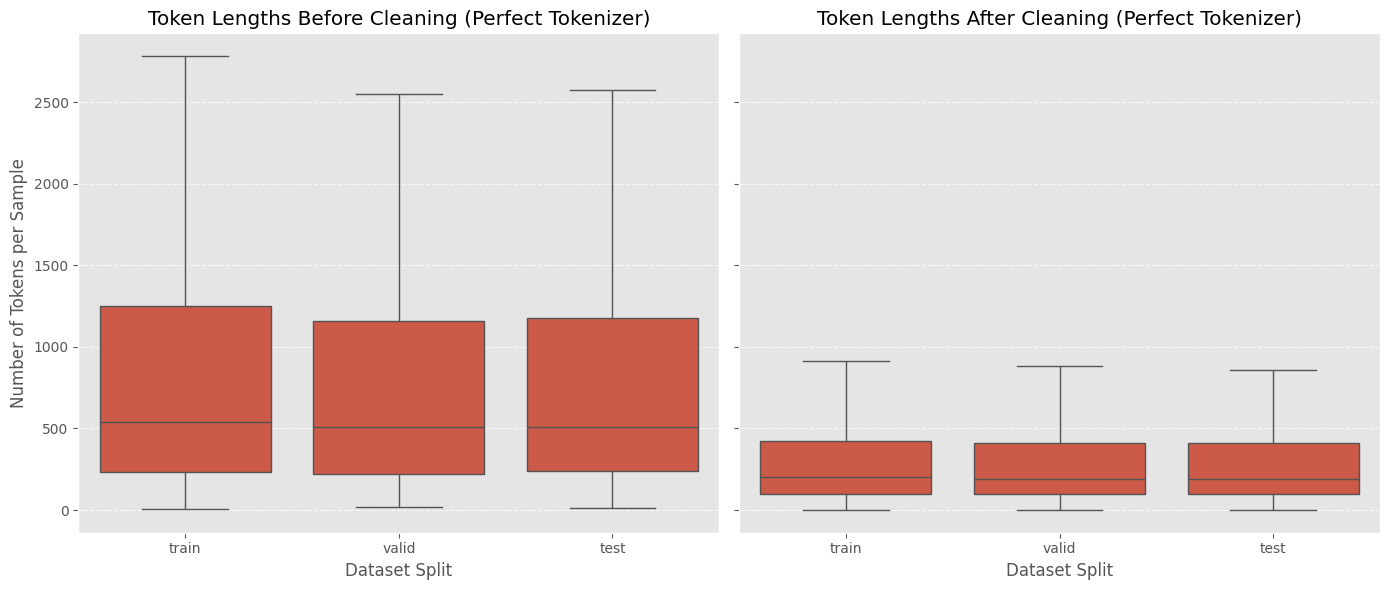

In [31]:
raw_data = []
raw_labels = []
clean_data = []
clean_labels = []

for split in ["train", "valid", "test"]:
    raw_data.extend(ds[split]["token_length_text1"])
    raw_labels.extend([split] * len(ds[split]["token_length_text1"]))

    clean_data.extend(ds[split]["token_length_cleaned_text1"])
    clean_labels.extend([split] * len(ds[split]["token_length_cleaned_text1"]))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(x=raw_labels, y=raw_data, ax=axes[0], showfliers=False)
axes[0].set_title("Token Lengths Before Cleaning (Perfect Tokenizer)")
axes[0].set_xlabel("Dataset Split")
axes[0].set_ylabel("Number of Tokens per Sample")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=clean_labels, y=clean_data, ax=axes[1], showfliers=False)
axes[1].set_title("Token Lengths After Cleaning (Perfect Tokenizer)")
axes[1].set_xlabel("Dataset Split")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [32]:
# let's look with the bert tokenizer
ds = ds.map(lambda x: get_n_tokens(x, tokenizers["bert-base-uncased"], key="bert_token_length_cleaned"), num_proc=48)

Map (num_proc=48):   0%|          | 0/18426 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (850 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Map (num_proc=48):   0%|          | 0/1538 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (761 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=48):   0%|          | 0/1539 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (649 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

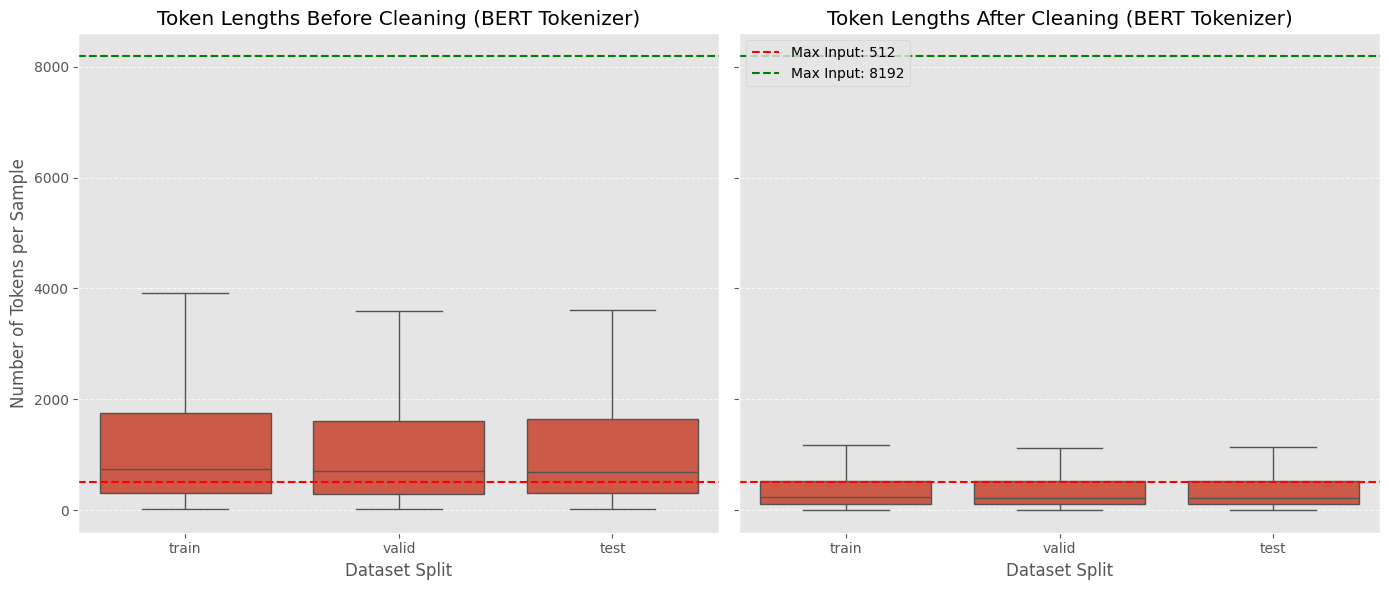

In [33]:
raw_data = []
raw_labels = []
clean_data = []
clean_labels = []

for split in ["train", "valid", "test"]:
    raw_data.extend(ds[split]["cde_token_length_text1"])
    raw_labels.extend([split] * len(ds[split]["cde_token_length_text1"]))

    clean_data.extend(ds[split]["bert_token_length_cleaned_text1"])
    clean_labels.extend([split] * len(ds[split]["bert_token_length_cleaned_text1"]))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(x=raw_labels, y=raw_data, ax=axes[0], showfliers=False)
axes[0].set_title("Token Lengths Before Cleaning (BERT Tokenizer)")
axes[0].axhline(y=512, color='r', linestyle='--', label=f"Max Input: 512")
axes[0].axhline(y=8192, color='g', linestyle='--', label=f"Max Input: 8192")
axes[0].set_xlabel("Dataset Split")
axes[0].set_ylabel("Number of Tokens per Sample")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.boxplot(x=clean_labels, y=clean_data, ax=axes[1], showfliers=False)
axes[1].set_title("Token Lengths After Cleaning (BERT Tokenizer)")
axes[1].axhline(y=512, color='r', linestyle='--', label=f"Max Input: 512")
axes[1].axhline(y=8192, color='g', linestyle='--', label=f"Max Input: 8192")
axes[1].set_xlabel("Dataset Split")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

> By removing all these useless tags, the size of the samples decreased consequently. Thanks to this preprocessing, a max context of 512 correspong now to the Q3, meaning that 75% of the samples have a size lower

In [35]:
train_df = ds["train"].to_pandas()
valid_df = ds["valid"].to_pandas()
test_df = ds["test"].to_pandas()

train_df.to_csv("../data/train.csv", index=False)
valid_df.to_csv("../data/valid.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

In [36]:
ds = load_dataset("csv", data_files={"train": "../data/train.csv", "valid": "../data/valid.csv", "test": "../data/test.csv"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [37]:
texts = []

for split in ["train", "valid", "test"]:
    texts.extend(ds[split]["text1"])
    texts.extend(ds[split]["text2"])

In [38]:
texts = [text for text in texts if text]

In [54]:
def estimate_vocab_richness(texts, tokenizer, step_size=100):
    seen_tokens = set()
    new_tokens_per_step = []
    
    for i in tqdm(range(0, len(texts), step_size)):
        batch = texts[i:i+step_size]
        try:
            tokens = tokenizer.batch_encode_plus(batch, add_special_tokens=False)["input_ids"]
        except:
            # case we use perfect tokenizer and not AutoTokenizer
            tokens = [tokenizer.encode(text, add_special_tokens=False).tokens for text
                        in batch]
        tokens = set([token for sublist in tokens for token in sublist])
        new_tokens = tokens - seen_tokens
        new_tokens_per_step.append(len(new_tokens))
        seen_tokens.update(new_tokens)
    
    return new_tokens_per_step

In [46]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

new_tokens_per_step_bert = estimate_vocab_richness(texts, tokenizer, step_size=10)

  0%|          | 0/4295 [00:00<?, ?it/s]

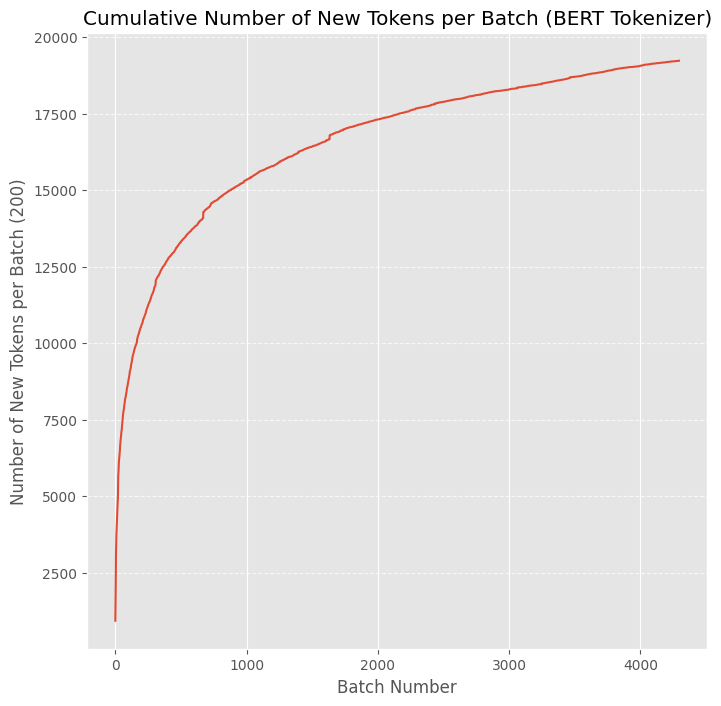

In [50]:
plt.figure(figsize=(8, 8))

plt.plot(np.cumsum(new_tokens_per_step_bert))

plt.xlabel("Batch Number")
plt.ylabel("Number of New Tokens per Batch (200)")
plt.title("Cumulative Number of New Tokens per Batch (BERT Tokenizer)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

> Let's try to compare some tokenizers using the same algorithm (BPE), we will pick them on MTEB and make sure that they don't have the same vocabulary

In [42]:
tokenizer_nv = AutoTokenizer.from_pretrained("nvidia/NV-Embed-v2")
tokenizer_gte = AutoTokenizer.from_pretrained("Alibaba-NLP/gte-Qwen2-7B-instruct")
tokenizer_bge = AutoTokenizer.from_pretrained("BAAI/bge-multilingual-gemma2")

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.7k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [43]:
print(tokenizer_nv.backend_tokenizer.model)
print(tokenizer_gte.backend_tokenizer.model)
print(tokenizer_bge.backend_tokenizer.model)

BPE(dropout=None, unk_token="<unk>", continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=True, byte_fallback=True, ignore_merges=False, vocab={"<unk>":0, "<s>":1, "</s>":2, "<0x00>":3, "<0x01>":4, ...}, merges=[("▁", "t"), ("i", "n"), ("e", "r"), ("▁", "a"), ("h", "e"), ...])
BPE(dropout=None, unk_token=None, continuing_subword_prefix="", end_of_word_suffix="", fuse_unk=False, byte_fallback=False, ignore_merges=False, vocab={"!":0, """:1, "#":2, "$":3, "%":4, ...}, merges=[("Ġ", "Ġ"), ("ĠĠ", "ĠĠ"), ("i", "n"), ("Ġ", "t"), ("ĠĠĠĠ", "ĠĠĠĠ"), ...])
BPE(dropout=None, unk_token="<unk>", continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=True, byte_fallback=True, ignore_merges=False, vocab={"<pad>":0, "<eos>":1, "<bos>":2, "<unk>":3, "<mask>":4, ...}, merges=[("
", "
"), ("
", "

"), ("

", "
"), ("
", "


"), ("

", "

"), ...])


In [ ]:
new_tokens_per_step_nv = estimate_vocab_richness(texts, tokenizer_nv, step_size=10)
new_tokens_per_step_bge = estimate_vocab_richness(texts, tokenizer_bge, step_size=10)
new_tokens_per_step_gte = estimate_vocab_richness(texts, tokenizer_gte, step_size=10)

  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/4295 [00:00<?, ?it/s]

  0%|          | 0/4295 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (43552 > 32768). Running this sequence through the model will result in indexing errors


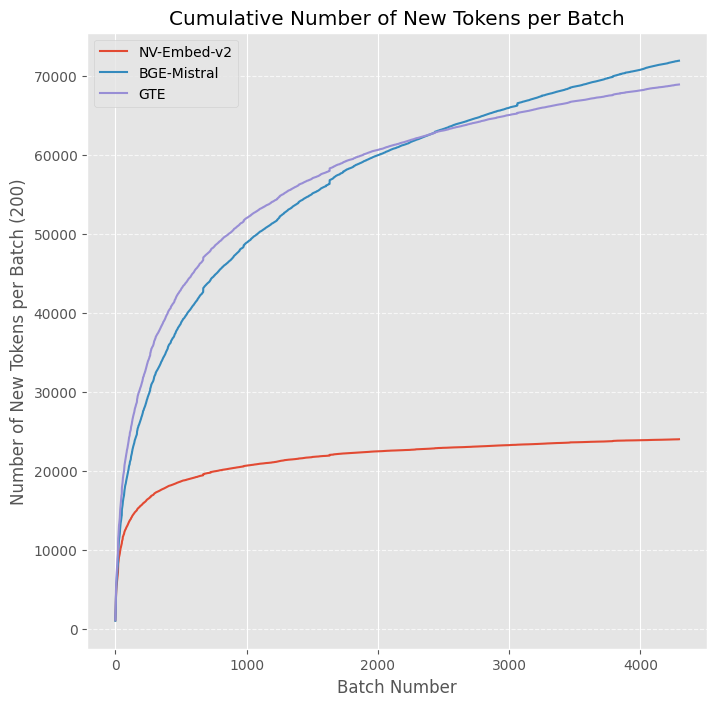

In [57]:
plt.figure(figsize=(8, 8))

plt.plot(np.cumsum(new_tokens_per_step_nv), label="NV-Embed-v2")
plt.plot(np.cumsum(new_tokens_per_step_bge), label="BGE-Mistral")
plt.plot(np.cumsum(new_tokens_per_step_gte), label="GTE")

plt.xlabel("Batch Number")
plt.ylabel("Number of New Tokens per Batch (200)")
plt.title("Cumulative Number of New Tokens per Batch")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.show()

> We have different behaviour, NVEMbed seems to platau largely faster than the tow others. We can already make an assumption, BPE split the words, more we split less the tokenizer know our corpus. So what we can suppose here, is that with NV-Embed, we split a lot the corpus because our vocab is not really aligned and this leads to have the same tokens batch after batch

> Let's see this statistically, we will perform a logistic regression where x is the number of characters an dy the number of tokens  
> If a curve is up to an other, that significate that the tokenizer split more and is consequently less aligned to our dataset.

In [59]:
nv_numb = {
    "n_tokens": [],
    "n_chars": []
}

bge_numb = {
    "n_tokens": [],
    "n_chars": []
}

gte_numb = {
    "n_tokens": [],
    "n_chars": []
}

for text in tqdm(texts[:4000]):
    nv_numb["n_tokens"].append(len(tokenizer_nv(text)["input_ids"]))
    nv_numb["n_chars"].append(len(text))

    bge_numb["n_tokens"].append(len(tokenizer_bge(text)["input_ids"]))
    bge_numb["n_chars"].append(len(text))

    gte_numb["n_tokens"].append(len(tokenizer_gte(text)["input_ids"]))
    gte_numb["n_chars"].append(len(text))

  0%|          | 0/4000 [00:00<?, ?it/s]

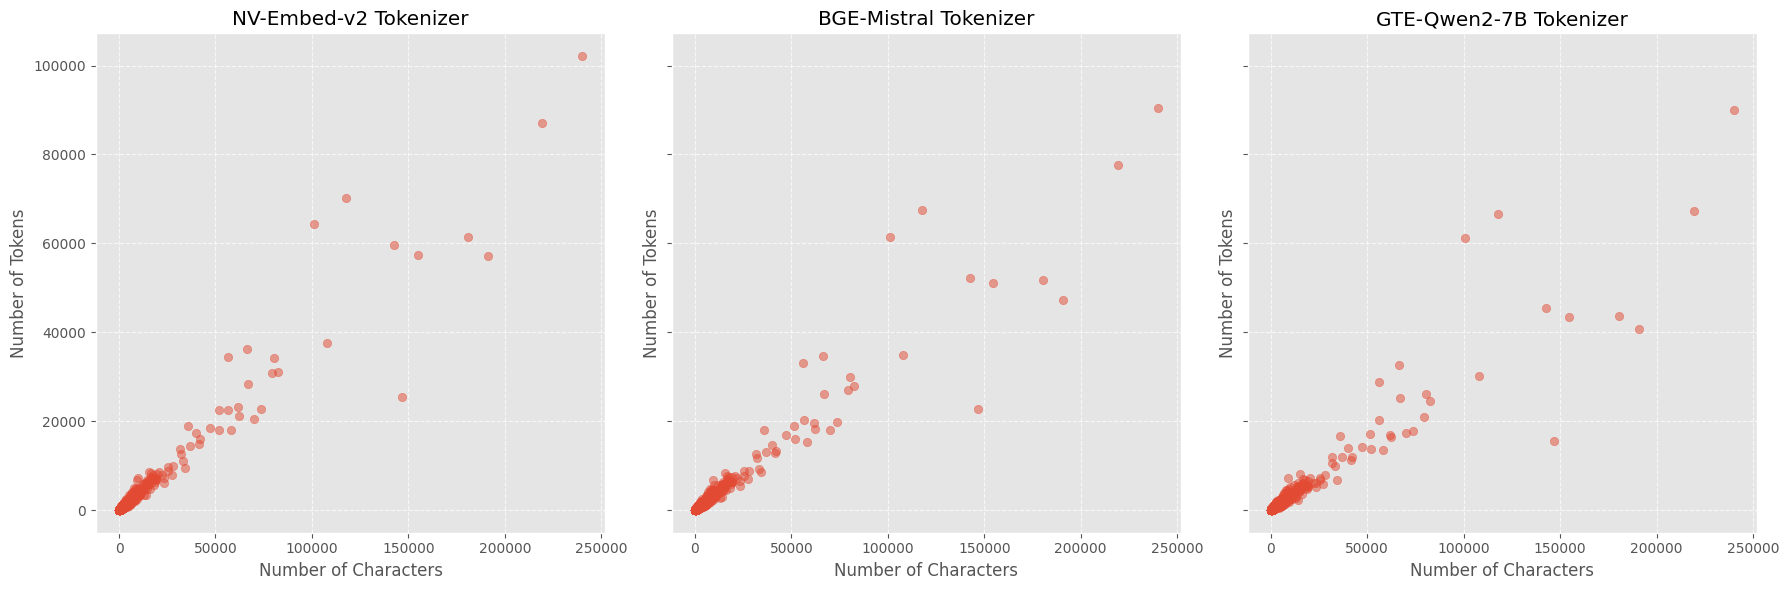

In [60]:
# we plot the number of tokens vs the number of characters
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)

axes[0].scatter(nv_numb["n_chars"], nv_numb["n_tokens"], alpha=0.5)
axes[0].set_title("NV-Embed-v2 Tokenizer")
axes[0].set_xlabel("Number of Characters")
axes[0].set_ylabel("Number of Tokens")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)

axes[1].scatter(bge_numb["n_chars"], bge_numb["n_tokens"], alpha=0.5)
axes[1].set_title("BGE-Mistral Tokenizer")
axes[1].set_xlabel("Number of Characters")
axes[1].set_ylabel("Number of Tokens")
axes[1].grid(axis="both", linestyle="--", alpha=0.7)

axes[2].scatter(gte_numb["n_chars"], gte_numb["n_tokens"], alpha=0.5)
axes[2].set_title("GTE-Qwen2-7B Tokenizer") 
axes[2].set_xlabel("Number of Characters")
axes[2].set_ylabel("Number of Tokens")
axes[2].grid(axis="both", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

> Plots are very similar

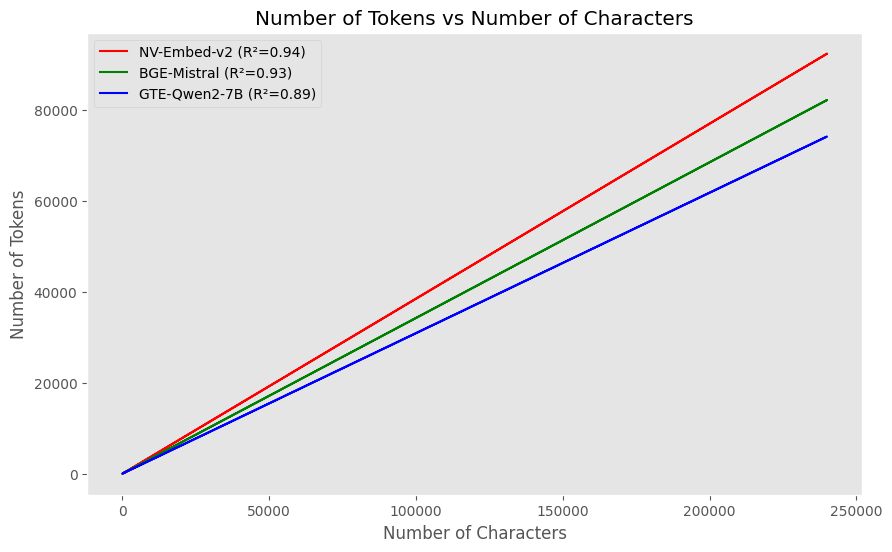

In [61]:
nv_df = pd.DataFrame(nv_numb)
bge_df = pd.DataFrame(bge_numb)
gte_df = pd.DataFrame(gte_numb)

def linear_regression(df, label, color):
    x = np.array(df["n_chars"])
    y = np.array(df["n_tokens"])
    
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    y_pred = slope * x + intercept

    plt.plot(x, y_pred, color=color, label=f"{label} (R²={r_value**2:.2f})")

plt.figure(figsize=(10, 6))

linear_regression(nv_df, "NV-Embed-v2", "r")
linear_regression(bge_df, "BGE-Mistral", "g")
linear_regression(gte_df, "GTE-Qwen2-7B", "b")

plt.xlabel("Number of Characters")
plt.ylabel("Number of Tokens")
plt.title("Number of Tokens vs Number of Characters")
plt.legend()
plt.grid()


plt.show()

> The tokenizer used for GTE seems to be the best because it don't split too much the whole corpus meaning that its tokenizer training set is aligned with our corpus (not certain, because of the R²)

> Unfortunately this model is too big for us and we won't be able to use it, but the idea with what I did here, is to show how you can have an a priori metric between models
based on the corpus used for training the tokenizer. Obviously, we talk about model having similar performances.

In [63]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [64]:
ds = ds.filter(lambda x: x["text1"] and x["text2"])

Filter:   0%|          | 0/18426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1538 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1539 [00:00<?, ? examples/s]

In [65]:
def get_number_of_unk(tokenizer, sample, key="n_unk"):
    return {
        key: tokenizer(sample["text1"], add_special_tokens=False)["input_ids"].count(tokenizer.unk_token_id) + tokenizer(sample["text2"], add_special_tokens=False)["input_ids"].count(tokenizer.unk_token_id)
    }

In [66]:
ds = ds.map(lambda x: get_number_of_unk(tokenizer, x), num_proc=48)

Map (num_proc=48):   0%|          | 0/18379 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (808 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (996 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=48):   0%|          | 0/1535 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (953 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=48):   0%|          | 0/1533 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1289 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [67]:
total_unk_tokens = sum(ds["train"]["n_unk"]) + sum(ds["valid"]["n_unk"]) + sum(ds["test"]["n_unk"])
print(f"Total number of unknown tokens: {total_unk_tokens}")

Total number of unknown tokens: 41229


In [68]:
cnt = 0
for i, sample in enumerate(ds["train"]):
    if sample["n_unk"] > 0:
        cnt += 1
        if cnt <= 3:
            print(sample['text1'])
            print("-"*80)
            print(tokenizer.tokenize(sample['text1']))
            print("-"*80)
            print(sample['text2'])
            print("-"*80)
            print(tokenizer.tokenize(sample['text2']))
            print("*"*80)
            print("*"*80)
        else:
            break

Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 512). Running this sequence through the model will result in indexing errors


System info

Playwright Version: [v1.31.2]
Operating System: [Windows VM]
Browser: [ONLY in Chromium]
Other info: It used to work fine until updated to v1.31 and now even if I revert back to previous versions still getting the same error (the error only happens in the Windows VM , not in my local machine, but I do not have access to that VM Windows machine)

Error LOG
2023-03-07T09:27:22.6036536Z �  1) [testing Login Setup] › tests\login-setup.ts:6:5 › Login Setup �────────────────────────────────��
2023-03-07T09:27:22.6037617Z 
2023-03-07T09:27:22.6038162Z     browserType.launch: Browser closed.
2023-03-07T09:27:22.6038793Z     ==================== Browser output: ====================
2023-03-07T09:27:22.6044850Z     <launching> C:\devops-agents\agent\_work\r65\a\Project.Web.Test.Automation\Output\node_modules\playwright-core\.local-browsers\chromium_win64_special-1050\chrome-win\chrome.exe --disable-field-trial-config --disable-background-networking --enable-features=NetworkService,N

> We can see that some chars come from an other language, so we can try to compare this tokenizer with a multilingual one

In [69]:
tokenizer_multilingual = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-small")

In [70]:
print(tokenizer_multilingual.backend_tokenizer.model)

Unigram(unk_id=3, vocab=[("<s>", 0), ("<pad>", 0), ("</s>", 0), ("<unk>", 0), (",", -3.4635426998138428), ...], byte_fallback=False)


In [71]:
ds = ds.map(lambda x: get_number_of_unk(tokenizer_multilingual, x, key="n_unk_multilingual"), num_proc=48)

Map (num_proc=48):   0%|          | 0/18379 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1948 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (869 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Map (num_proc=48):   0%|          | 0/1535 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (940 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (855 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (995 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=48):   0%|          | 0/1533 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1314 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3023 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (715 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

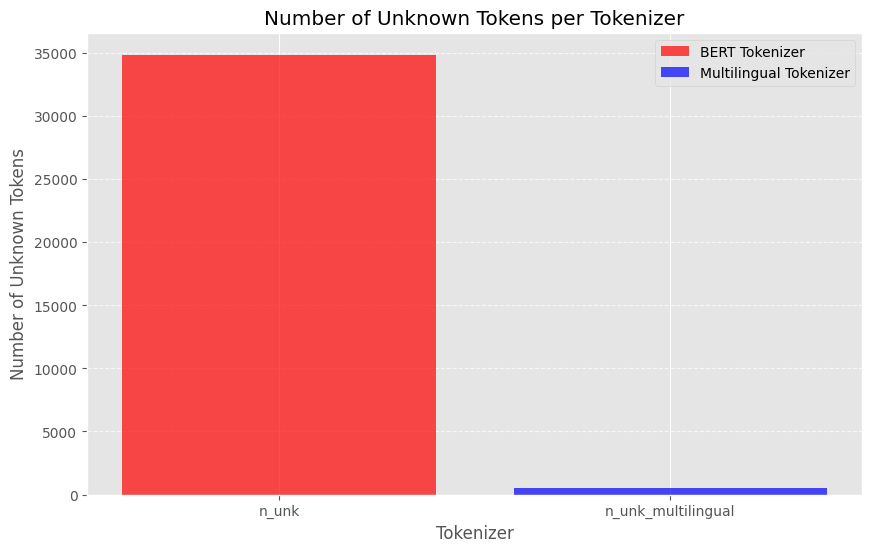

In [72]:
plt.figure(figsize=(10, 6))

plt.bar("n_unk", sum(ds["train"]["n_unk"]), color="r", alpha=0.7, label="BERT Tokenizer")
plt.bar("n_unk_multilingual", sum(ds["train"]["n_unk_multilingual"]), color="b", alpha=0.7, label="Multilingual Tokenizer")
plt.xlabel("Tokenizer")
plt.ylabel("Number of Unknown Tokens")
plt.title("Number of Unknown Tokens per Tokenizer")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

> According to this and also the vocab of the perfect tokenizer, we can consider that the corpus is not only in english.

> EDA Conclusion:
> - We can compare SBERT model with different max context length (e.g 512 vs 8192)  
> - We can try a multilingual one  
> - We know that some tokenizer are more aligned with our corpus